In [1]:
import numpy as np
import pandas as pd
import kagglehub
import datetime as dt
import math 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

Load Data

In [2]:
df = pd.read_csv('Donations_accepted_by_political_parties.csv', dtype={
    'index': 'int64',
    'ECRef' : 'string',
    'RegulatedEntityName': 'category',
    'RegulatedEntityType': 'category',
    'Value': 'string',
    "AcceptedDate": 'string',
    "AccountingUnitName": 'category',
    "DonorName": 'category',
    "AccountingUnitsAsCentralParty": 'bool',
    'IsSponsorship': 'bool',
    'DonorStatus': 'category',
    'RegulatedDoneeType': 'category',
    'CompanyRegistrationNumber': 'string',
    'Postcode': 'string',
    'DonationType': 'category',
    'NatureOfDonation': 'category',
    'PurposeOfVisit': 'string',
    'DonationAction': 'category',
    'ReceivedDate': 'string',
    'ReportedDate': 'string',
    'IsReportedPrePoll': 'string',
    'ReportingPeriodName': 'string',
    'IsBequest': 'bool',
    'IsAggregation': 'bool',
    'RegulatedEntityId': 'category',
    'AccountingUnitId': 'category',
    'DonorId': 'category',
    'CampaigningName': 'category',
    'RegisterName': 'string',
    'IsIrishSource': 'category'
    })

Correct Datatypes

In [3]:
df['Value'] = df['Value'].replace({'\£': '', ',': ''}, regex=True).astype(float)
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'], format='%d/%m/%Y')
df['ReportedDate'] = pd.to_datetime(df['ReportedDate'], format='%d/%m/%Y')
df['AcceptedDate'] = pd.to_datetime(df['AcceptedDate'], format='%d/%m/%Y')

Review Data to identify Unnecessary Columns and Potential improved Index

In [4]:
summary_df = pd.DataFrame({
    'DataType': df.dtypes,
    'UniqueValues': df.nunique()
}).reset_index().rename(columns={'index': 'Column'})
print(summary_df)

                           Column        DataType  UniqueValues
0                           index           int64         65278
1                           ECRef          string         65278
2             RegulatedEntityName        category          1384
3             RegulatedEntityType        category             4
4                           Value         float64         11253
5                    AcceptedDate  datetime64[ns]          6265
6              AccountingUnitName        category          1856
7                       DonorName        category         19010
8   AccountingUnitsAsCentralParty            bool             2
9                   IsSponsorship            bool             2
10                    DonorStatus        category            13
11             RegulatedDoneeType        category            13
12      CompanyRegistrationNumber          string          3558
13                       Postcode          string          4559
14                   DonationType       

Change index to ECRef as evidently a unique identifier

In [5]:
df.set_index('ECRef')
df.describe()

,index,Value
count,65278.000000,6.527800e+04
mean,32638.500000,1.672815e+04
std,18844.279773,8.377591e+04
min,0.000000,0.000000e+00
25%,16319.250000,1.530000e+03
50%,32638.500000,3.000000e+03
75%,48957.750000,9.000000e+03
max,65277.000000,5.000000e+06


Review DonorStatus, DonationAction, DonationType, NatureOfDonation

In [6]:
df.groupby('DonorStatus').agg('count')

,index,ECRef,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,...,IsReportedPrePoll,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource
DonorStatus,,,,,,,,,,,,,,,,,,,,,
Building Society,3,3,3,3,3,3,0,3,3,3,...,2,3,3,3,3,0,3,0,3,3
Company,11883,11883,11883,11883,11883,11712,9756,11883,11883,11883,...,8567,11883,11883,11883,11883,5272,11883,2,11558,11883
Friendly Society,659,659,659,659,659,659,650,659,659,659,...,573,659,659,659,659,296,659,0,659,659
Impermissible Donor,254,254,254,254,254,2,220,254,254,254,...,182,254,254,254,254,64,254,0,248,254
Individual,29434,29434,29434,29434,29434,28977,26529,29430,29434,29434,...,21688,29434,29434,29434,29434,16330,29434,3,28684,29434
Limited Liability Partnership,477,477,477,477,477,475,424,477,477,477,...,423,477,477,477,477,104,477,0,471,477
Other,1757,1757,1757,1757,1757,1754,33,1757,1757,1757,...,955,1757,1757,1757,1757,20,1757,0,1744,1757
Public Fund,1726,1726,1726,1726,1726,1720,1643,1726,1726,1726,...,972,1726,1726,1726,1726,289,1726,0,1713,1726
Registered Political Party,1029,1029,1029,1029,1029,1029,918,1029,1029,1029,...,862,1029,1029,1029,1029,774,1029,0,1022,1029


In [7]:
df.groupby('DonationAction').agg('count')

,index,ECRef,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,...,IsReportedPrePoll,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource
DonationAction,,,,,,,,,,,,,,,,,,,,,
Deferred,19,19,19,19,19,0,17,16,19,19,...,15,19,19,19,19,9,16,0,18,16
Forfeited,33,33,33,33,33,0,31,20,33,33,...,25,33,33,33,33,20,20,0,33,20
Returned,231,231,231,231,231,0,202,220,231,231,...,162,231,231,231,231,48,224,0,226,224


In [8]:
df.groupby('DonationType').agg('count')

,index,ECRef,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,...,IsReportedPrePoll,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource
DonationType,,,,,,,,,,,,,,,,,,,,,
Cash,51642,51642,51642,51642,51642,51008,47581,51642,51642,51642,...,38899,51642,51642,51642,51642,31333,51642,5,50561,51642
Exempt Trust,469,469,469,469,469,468,467,469,469,469,...,397,469,469,469,469,432,469,0,467,0
Non Cash,8308,8308,8308,8308,8308,8271,6993,8308,8308,8308,...,6554,8308,8308,8308,8308,4214,8308,0,8229,8308
Permissible Donor Exempt Trust,171,171,171,171,171,171,10,171,171,171,...,170,171,171,171,171,10,171,0,171,0
Public Funds,1713,1713,1713,1713,1713,1713,1638,1713,1713,1713,...,971,1713,1713,1713,1713,289,1713,0,1708,1713
Visit,2634,2634,2634,2634,2634,2634,18,2634,2634,2634,...,1704,2634,2634,2634,2634,0,2634,0,2634,2634
Impermissible Donor,260,260,260,260,260,0,228,256,260,260,...,186,260,260,260,260,67,260,0,254,260
Total value of donations not reported individually,58,58,58,58,58,0,0,0,58,58,...,39,58,58,58,58,0,0,0,0,0
Unidentified Donor,23,23,23,23,23,0,22,0,23,23,...,16,23,23,23,23,10,0,0,23,0


In [9]:
df.groupby('NatureOfDonation').agg('count')

,index,ECRef,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,...,IsReportedPrePoll,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource
NatureOfDonation,,,,,,,,,,,,,,,,,,,,,
Administration services,456,456,456,456,456,454,378,456,456,456,...,228,456,456,456,456,282,456,0,452,456
Advertising,1168,1168,1168,1168,1168,1158,1069,1168,1168,1168,...,1047,1168,1168,1168,1168,663,1168,0,1155,1163
Assistance for Parties (Scottish Parliament),311,311,311,311,311,311,288,311,311,311,...,234,311,311,311,311,69,311,0,311,311
Auction prizes,628,628,628,628,628,626,608,628,628,628,...,485,628,628,628,628,220,628,0,628,628
Consultancy services,377,377,377,377,377,375,292,377,377,377,...,301,377,377,377,377,116,377,0,371,377
Cranborne Money (House of Lords),162,162,162,162,162,162,140,162,162,162,...,105,162,162,162,162,34,162,0,162,162
Financial Assistance for Parties in NI Assembly,259,259,259,259,259,259,259,259,259,259,...,0,259,259,259,259,12,259,0,259,259
Hospitality,184,184,184,184,184,184,133,184,184,184,...,139,184,184,184,184,59,184,0,184,184
Loan conversion,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,7,39,0,39,39


Remove the 
"Impermissible Donor" DonorStatus
"Forfeited" and "Returned" DonationActions.
"Impermissible Donor" DonationType

Copy removed records to "ExcludedData" dataframe, then create CleanedData Dataframe excluding the identified records

In [10]:
#Excludeddata = df[(df['DonorStatus']=="Impermissible Donor") | (df['DonationActions']==('Forfeited', 'Returned')) | (df[Donationtype]=='Impermissible Donor')]

Excludeddata = df[(df['DonorStatus']=="Impermissible Donor") | (df['DonationAction']==('Forfeited' , 'Returned'))| (df['DonationType']=='Impermissible Donor') | (df['RegulatedEntityType']!='Political Party')]
Excludeddata

,index,ECRef,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,...,IsReportedPrePoll,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource
0,0,NC0408174,Mr Andy Street,Regulated Donee,1876.56,2019-09-02,NaN,Conservative and Unionist Party,False,False,...,<NA>,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
1,1,NC0408173,Mr Andy Street,Regulated Donee,2700.00,2019-09-02,NaN,Conservative and Unionist Party,False,False,...,<NA>,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
2,2,NC0408177,Mr Andy Street,Regulated Donee,4852.58,2019-08-30,NaN,Conservative and Unionist Party,False,False,...,<NA>,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
3,3,NC0408176,Mr Andy Street,Regulated Donee,2500.00,2019-08-30,NaN,Conservative and Unionist Party,False,False,...,<NA>,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
4,4,NC0408170,Mr Andy Street,Regulated Donee,4524.05,2019-08-29,NaN,Conservative and Unionist Party,False,False,...,<NA>,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65271,65271,I0034020,Liberal Democrats,Political Party,1000.00,NaT,Central Party,Mr Ghazi Al-Jumaily,False,False,...,False,Q2 2009,False,False,90,NaN,33550.0,NaN,Great Britain,False
65272,65272,TV0049377,Labour No To AV,Third Party,5382.31,NaT,NaN,NaN,False,False,...,False,Scottish Parliament election 05/05/2011,False,False,1739,NaN,NaN,NaN,<NA>,NaN
65273,65273,C0242478,Vote Leave Limited,Permitted Participant,10000.00,NaT,NaN,Shaftesbury Investments,False,False,...,<NA>,Pre-poll 1 (01/02/2016 - 21/04/2016) for the R...,False,False,3945,NaN,74198.0,NaN,<NA>,False
65274,65274,C0242461,Vote Leave Limited,Permitted Participant,100000.00,NaT,NaN,Mr Jeremy Hosking,False,False,...,<NA>,Pre-poll 1 (01/02/2016 - 21/04/2016) for the R...,False,False,3945,NaN,74184.0,NaN,<NA>,False


In [11]:
df = df[~df.index.isin(Excludeddata.index)]
df.reindex()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56729 entries, 72 to 65277
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          56729 non-null  int64         
 1   ECRef                          56729 non-null  string        
 2   RegulatedEntityName            56729 non-null  category      
 3   RegulatedEntityType            56729 non-null  category      
 4   Value                          56729 non-null  float64       
 5   AcceptedDate                   56393 non-null  datetime64[ns]
 6   AccountingUnitName             56729 non-null  category      
 7   DonorName                      56707 non-null  category      
 8   AccountingUnitsAsCentralParty  56729 non-null  bool          
 9   IsSponsorship                  56729 non-null  bool          
 10  DonorStatus                    56729 non-null  category      
 11  RegulatedDonee

In [12]:
df.groupby('DonationType').Value.agg(['min', 'max', 'sum', 'count', 'mean', 'median'])

,min,max,sum,count,mean,median
DonationType,,,,,,
Cash,0.00,5000000.00,7.347523e+08,47581,15442.137132,2502.000
Exempt Trust,350.00,330272.00,3.503428e+06,467,7501.987837,2500.000
Non Cash,10.96,1647500.00,5.863101e+07,6993,8384.242212,2378.770
Permissible Donor Exempt Trust,1200.00,20000.00,6.073990e+04,10,6073.990000,2422.980
Public Funds,250.00,3685124.97,1.589302e+08,1638,97026.954219,13383.845
Visit,3001.60,47252.72,2.655783e+05,18,14754.348333,11671.250
Impermissible Donor,NaN,NaN,0.000000e+00,0,NaN,NaN
Total value of donations not reported individually,NaN,NaN,0.000000e+00,0,NaN,NaN
Unidentified Donor,300.00,10000.00,4.645000e+04,22,2111.363636,1000.000


Going to try to create a ML model that predicts the size of a donation based on the donor, donee, 

Step one is to create a grouping based on the Value donated.

In [13]:
maxvalue = df.Value.max()
print(maxvalue)

5000000.0


In [14]:
valueCategory = [0, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 250000, 500000, 750000, 1000000, 2000000]

maxvalue = df.Value.max()

def categorize(total):
    if np.isnan(total):
        return None
    else: 
        for VC in valueCategory:        
            if total <= VC:
                return VC
            else:
                pass
        return maxvalue

df['Value_Category'] = df.Value.apply(categorize)

In [15]:
value_summary_df = df.groupby(['Value_Category']).agg({'Value': ['sum', 'count']})
value_summary_df

Value      
                         sum count
Value_Category                    
0.0             0.000000e+00     2
1000.0          5.563403e+06  8301
1500.0          8.732769e+06  6720
2000.0          1.680020e+07  9010
2500.0          9.047085e+06  3827
3000.0          9.050547e+06  3131
4000.0          9.495178e+06  2610
5000.0          2.152652e+07  4426
7500.0          2.039045e+07  3307
10000.0         4.537333e+07  4849
25000.0         9.253093e+07  5388
50000.0         1.040260e+08  2507
75000.0         4.017970e+07   662
100000.0        4.951853e+07   528
250000.0        1.317370e+08   792
500000.0        1.567714e+08   445
750000.0        5.495796e+07    89
1000000.0       4.588238e+07    51
2000000.0       9.963304e+07    72
5000000.0       3.497328e+07    12

<AxesSubplot:xlabel='DonationMean', ylabel='DonationEvents'>

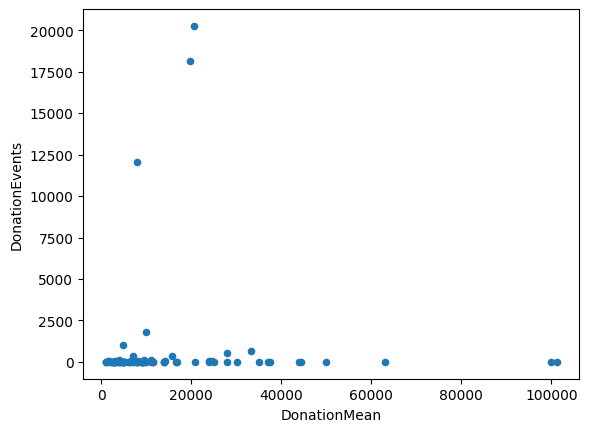

In [16]:
RegulatedEntity_df = df.groupby(['RegulatedEntityName']).agg({'Value': ['sum', 'count', 'mean']})

RegulatedEntity_df.columns = [ 'DonationsValue', 'DonationEvents', 'DonationMean']

RegulatedEntity_df.plot(kind = 'scatter', x = 'DonationMean', y = 'DonationEvents')

<AxesSubplot:xlabel='RegulatedEntityName'>

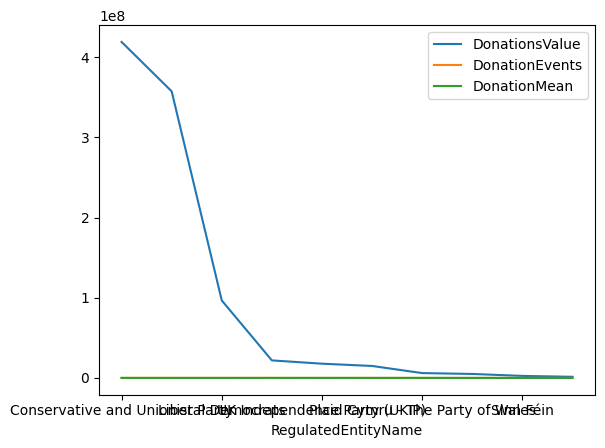

In [17]:
RegulatedEntity_df.groupby(['DonationEvents']).agg('count')
RegulatedEntity_df.sort_values(by=['DonationsValue'], ascending=False).head(n=10).plot()


In [18]:
RegulatedEntity_df.sort_values(by=['DonationsValue'], ascending=True).head(n=20)

,DonationsValue,DonationEvents,DonationMean
RegulatedEntityName,,,
Abisola Ifasawo,0.0,0,NaN
Tulip Siddiq,0.0,0,NaN
Trade Unionists Against The European Union,0.0,0,NaN
Tomos Davies,0.0,0,NaN
Tom Watson MP,0.0,0,NaN
Tom Tugendhat,0.0,0,NaN
Tom Pursglove MP,0.0,0,NaN
The Young Britons' Foundation,0.0,0,NaN
UK-EU Open Policy Limited (campaign name: Best for Britain),0.0,0,NaN


In [19]:
RegulatedEntity_df.sort_values(by=['DonationEvents'], ascending=False).head(n=20)

,DonationsValue,DonationEvents,DonationMean
RegulatedEntityName,,,
Conservative and Unionist Party,4.191088e+08,20255,20691.624275
Labour Party,3.574911e+08,18122,19726.911000
Liberal Democrats,9.664990e+07,12074,8004.795278
UK Independence Party (UKIP),1.774309e+07,1801,9851.797274
Green Party,4.958368e+06,1039,4772.250472
Scottish National Party (SNP),2.187222e+07,659,33190.013399
Co-operative Party,1.492238e+07,534,27944.522603
Plaid Cymru - The Party of Wales,6.036398e+06,386,15638.335596
Sinn Féin,2.506699e+06,359,6982.448774


In [47]:
RegulatedEntity_df.sort_values(by=['DonationEvents'], ascending=False).head(n=40)

,DonationsValue,DonationEvents,DonationMean
RegulatedEntityName,,,
Conservative and Unionist Party,4.191088e+08,20255,20691.624275
Labour Party,3.574911e+08,18122,19726.911000
Liberal Democrats,9.664990e+07,12074,8004.795278
UK Independence Party (UKIP),1.774309e+07,1801,9851.797274
Green Party,4.958368e+06,1039,4772.250472
Scottish National Party (SNP),2.187222e+07,659,33190.013399
Co-operative Party,1.492238e+07,534,27944.522603
Plaid Cymru - The Party of Wales,6.036398e+06,386,15638.335596
Sinn Féin,2.506699e+06,359,6982.448774


In [48]:
RegulatedEntity_df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1384 entries, Abisola Ifasawo to women4theworld [De-registered 08/06/09]
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DonationsValue  1384 non-null   float64
 1   DonationEvents  1384 non-null   int64  
 2   DonationMean    86 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 98.5 KB


In [55]:
#DonorGrouping = [0, 1, 10, 2000, 2500, 3000, 4000, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 250000, 500000, 750000, 1000000, 2000000]

def RegulatedEntityGroup(RegulatedEntityNameVar):
    RE_Events = RegulatedEntity_df[RegulatedEntity_df.index == RegulatedEntityNameVar]
    
    if RE_Events.DonationEvents.agg(sum) ==0:
        return 'No Relevant Donations'
    elif RE_Events.DonationEvents.agg(sum) <=1:
        return 'Single Donor Entity'
    elif RE_Events.DonationEvents.agg(sum) <=10:
        return 'Very Small Entity'
    elif RE_Events.DonationEvents.agg(sum) <=50:
        return 'Small Entity'
    elif RE_Events.DonationEvents.agg(sum) <=100:
        return 'Medium Entity'
    else:
        return RegulatedEntityNameVar


df['RegEntity_Group'] = df.RegulatedEntityName.apply(RegulatedEntityGroup)

df.groupby(['RegEntity_Group']).agg({'Value': ['sum', 'count', 'mean']})

Value         \
                                                          sum  count   
RegEntity_Group                                                        
British National Party [De-registered 08/01/16]  1.393671e+06    125   
Co-operative Party                               1.492238e+07    534   
Conservative and Unionist Party                  4.191088e+08  20255   
Green Party                                      4.958368e+06   1039   
Labour Party                                     3.574911e+08  18122   
Liberal Democrats                                9.664990e+07  12074   
Medium Entity                                    2.436052e+06    424   
Plaid Cymru - The Party of Wales                 6.036398e+06    386   
Scottish National Party (SNP)                    2.187222e+07    659   
Scottish Socialist Party                         5.584151e+05    145   
Single Donor Entity                              3.548653e+05     15   
Sinn Féin                                        2.506699e+06    359   
Small Entity                                     7.173477e+06    507   
The New Party [De-registered 01/07/10]           1.382820e+06    146   
UK Independence Party (UKIP)                     1.774309e+07   1801   
Very Small Entity                                1.601404e+06    138   

                                                               
                                                         mean  
RegEntity_Group                                                
British National Party [De-registered 08/01/16]  11149.370560  
Co-operative Party                               27944.522603  
Conservative and Unionist Party                  20691.624275  
Green Party                                       4772.250472  
Labour Party                                     19726.911000  
Liberal Democrats                                 8004.795278  
Medium Entity                                     5745.406675  
Plaid Cymru - The Party of Wales                 15638.335596  
Scottish National Party (SNP)                    33190.013399  
Scottish Socialist Party                          3851.138552  
Single Donor Entity                              23657.686667  
Sinn Féin                                         6982.448774  
Small Entity                                     14148.869744  
The New Party [De-registered 01/07/10]            9471.369041  
UK Independence Party (UKIP)                      9851.797274  
Very Small Entity                                11604.380435

In [16]:
ElectionDates = ['2001/06/07 00:00:00','2005/05/05 00:00:00','2010/06/05 00:00:00', '2015/07/05 00:00:00', '2017/07/05 00:00:00', '2019/12/12 00:00:00', '2024/07/04 00:00:00']

def GenElectionRelation(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = DaysDiff.days
            return delta
        else:
            pass
    return 0

df['DaysToNextElection'] = df.ReceivedDate.apply(GenElectionRelation)


In [17]:
def GenElectionRelation2(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = math.ceil((DaysDiff.days)/7)
            return delta
        else:
            pass
    return 0

df['WeeksToNextElection'] = df.ReceivedDate.apply(GenElectionRelation2)

<AxesSubplot:xlabel='WeeksToNextElection', ylabel='Value'>

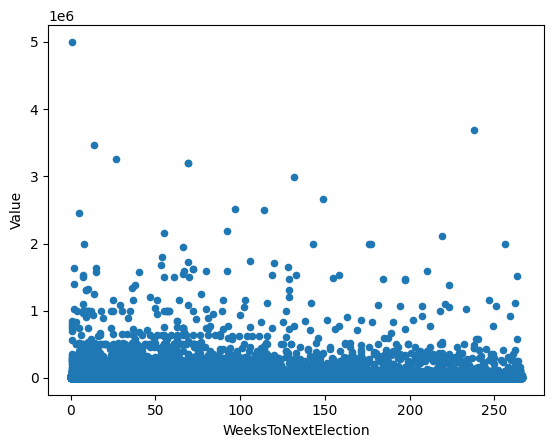

In [19]:
df.plot(kind = 'scatter', x = 'WeeksToNextElection', y = 'Value')


Column list
""".drop(
'ECRef', 
#'RegulatedEntityName',
'RegulatedEntityType',
#'Value',
'AcceptedDate',
'AccountingUnitName',
'DonorName',
'AccountingUnitsAsCentralParty',
'IsSponsorship',
'DonorStatus',
'RegulatedDoneeType',
'CompanyRegistrationNumber',
'Postcode',
'DonationType',
'NatureOfDonation',
'PurposeOfVisit',
'DonationAction',
#'ReceivedDate',
'ReportedDate',
'IsReportedPrePoll',
'ReportingPeriodName',
'IsBequest',
'IsAggregation',
'RegulatedEntityId',
'AccountingUnitId',
'DonorId',
'CampaigningName',
'RegisterName',
'IsIrishSource'
)
"""

<AxesSubplot:ylabel='Frequency'>

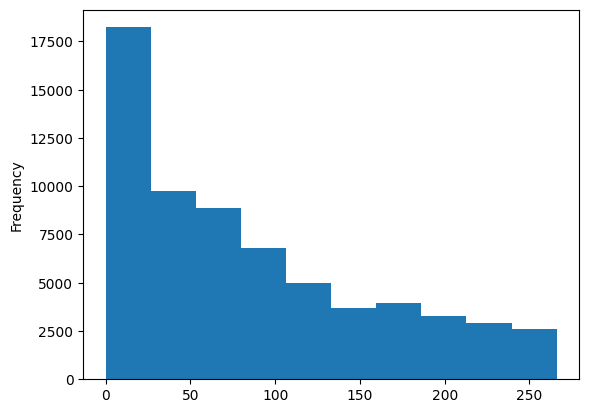

In [20]:
df["WeeksToNextElection"].plot(kind = 'hist')


In [21]:
PlotData = df[(df['RegulatedEntityType'] =="Political Party") 
    & (df["RegulatedEntityName"].str.contains('registered')==False)
    ]
PlotData.reindex()

,index,ECRef,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,...,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource,Value_Category,DaysToNextElection,WeeksToNextElection
72,72,PF0406817,Scottish National Party (SNP),Political Party,67307.96,2019-07-21,SNP Westminster Parliament Group,House of Commons,False,False,...,False,102,5205.0,33390.0,NaN,Great Britain,False,75000.0,144,21
100,100,PF0407564,Plaid Cymru - The Party of Wales,Political Party,43784.46,2019-07-08,Central Party,Y Comisiwn Etholiadol,False,False,...,False,77,NaN,87425.0,NaN,Great Britain,False,50000.0,171,25
122,122,C0406523,The Brexit Party,Political Party,10000.00,2019-07-03,Central Party,Mr Malcolm Bluemel,False,False,...,False,7931,NaN,87138.0,NaN,Great Britain,False,10000.0,170,25
132,132,NC0407490,Conservative and Unionist Party,Political Party,12000.00,2019-07-01,Central Party,Laurence Stephen Geller,False,False,...,False,52,NaN,86338.0,NaN,Great Britain,False,25000.0,167,24
135,135,C0406408,Liberal Democrats,Political Party,2300.00,2019-06-30,Westmorland and Lonsdale,Kendal & South Westmoreland Liberal Club,False,False,...,True,90,2386.0,35426.0,NaN,Great Britain,False,2500.0,193,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65239,65239,C0319722,Conservative and Unionist Party,Political Party,10000.00,NaT,Central Party,Mrs Jelena Guadagnini,False,False,...,False,52,NaN,78099.0,NaN,Great Britain,False,10000.0,40,6
65251,65251,C0319715,Conservative and Unionist Party,Political Party,12500.00,NaT,Central Party,Dr Peter Andrew Cruddas,False,False,...,False,52,NaN,67253.0,NaN,Great Britain,False,25000.0,41,6
65254,65254,C0319443,Liberal Democrats,Political Party,10000.00,NaT,Central Party,Mr Robert Devereux,False,False,...,False,90,NaN,78008.0,NaN,Great Britain,False,10000.0,51,8
65276,65276,C0319710,Conservative and Unionist Party,Political Party,50000.00,NaT,Central Party,Mr Peter A Dubens,False,False,...,False,52,NaN,34241.0,NaN,Great Britain,False,50000.0,41,6
